In [188]:
import os
# import sys
# import collections
# import re
# import math
import random
import time
from itertools import chain

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Flatten
from keras.layers import Input, Dense, LSTM, CuDNNLSTM, Concatenate, Activation, GRU, SimpleRNN
from keras.models import Model, load_model
from keras.utils import np_utils
from keras import regularizers

from fastprogress import master_bar, progress_bar

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
matplotlib.use('pdf')

In [189]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [190]:
# 元データのファイル構造のままで実行できるようにするにはos.walk()とか使えば良さそう。
subjects=['A','B','C','D','E','F','G','H','I']
# subjects=['A','B','C','D','E','I']
# エキスパートの中でも異常発見数が多い人、経験年数が長い人を選ぶ
# subjects=['A','D','E','F','G','I']
sub_level={'A':'E','B':'E','C':'E','D':'N','E':'N','F':'E','G':'E','H':'E','I':'N'}
sub_heights={'A':1.680,'B':1.780,'C':1.750,'D':1.750,'E':1.700,'F':1.680,'G':1.710,'H':1.658,'I':1.670}
eng_to_num={'A':'1','B':'2','C':'3','D':'4','E':'5','F':'6','G':'7','H':'8','I':'9'}
num_to_eng={'1':'A','2':'B','3':'C','4':'D','5':'E','6':'F','7':'G','8':'H','9':'I'}
log_type='Eyelog'
MAX_TRIAL_NUM=10
# logのB002(3回目)がない。それに対応するB10のエクセルもない。
path_to_original_log='./log'
path_to_excel='./視線分析'
classes = ['E', 'N']
nb_classes = len(classes)

root_path='./OIL_DATA'
path_to_log=root_path+'/'+log_type
path_to_new_log=path_to_log+'/log_data'
path_to_transcriptions=path_to_log+'/transcriptions'
path_to_supertrialout=root_path+'/Experimental_setup/Eyelog/unBalanced/GestureClassification/SuperTrialOut'

In [191]:
def create_dir(out_dir):
    if os.path.exists(out_dir):
        return None
    else:
        try:
            os.makedirs(out_dir)
        except:
            # in case another machine created the path meanwhile
            return None
        return out_dir

def readFile(file_name, dtype, columns_to_use=None):
    X = np.loadtxt(file_name, dtype, usecols=columns_to_use)
    return X


In [192]:
encoder = LabelEncoder()  # used to transform labels into binary one hot vectors

def fit_encoder(y_train, y_test, y_val):
    y_train_test_val = y_train + y_test + y_val
    encoder.fit(y_train_test_val)

def convertStringClassesToBinaryClasses(y_train, y_test, y_val):
    idx_y_test = len(y_train)
    idx_y_val = len(y_train) + len(y_test)
    y_train_test_val = y_train + y_test + y_val
    y_train_test_val = encoder.transform(y_train_test_val)
    y_train_test_val = np_utils.to_categorical(y_train_test_val)
    y_train = y_train_test_val[0:idx_y_test]
    y_test = y_train_test_val[idx_y_test:idx_y_val]
    y_val = y_train_test_val[idx_y_val:]
    return y_train, y_test, y_val

# the sequence variable is the multivariate time series or in this case the surgical task
# we want to split the inputs in order to train
def split_input_for_training(sequence):
    # get number of hands
    num_hands = len(input_shapes)
    # get number of dimensions cluster for each hand
    num_dim_clusters = len(input_shapes[0])
    # define the new input sequence
    x = []
    # this is used to keep track of the assigned dimensions
    last = 0
    # loop over each hand
    for i in range(num_hands):
        # loop for each hand over the cluster of dimensions
        for j in range(num_dim_clusters):
            # assign new input same length but different dimensions each time
            x.append(np.array([sequence[:, last:(last + input_shapes[i][j][1])]]))
            # remember last assigned
            last = input_shapes[i][j][1]
    # return the new input
    return x

# shuffles train and labels
def shuffle(x_train, y_train):
    y_train = np.array(y_train)
    y_train = y_train.reshape(len(y_train), 1)
    x_train = x_train.reshape(len(x_train), 1)
    x_y_train = np.concatenate((x_train, y_train), axis=1)
    np.random.shuffle(x_y_train)
    return x_y_train[:, 0], x_y_train[:, 1].tolist()

def evaluate_for_epoch(model, x_test, y_test):
    epoch_test_loss = 0
    for test, label in zip(x_test, y_test):
        loss, acc = model.evaluate(split_input_for_training(test), label.reshape(1, nb_classes), verbose=0)
        epoch_test_loss += loss  ############### change if monitor loss instead of accuracy
    return epoch_test_loss / len(x_test)

In [193]:
def evaluateModel(model, x_test, y_test_binary):
    confusion_matrix_f = pd.DataFrame(np.zeros(shape=(nb_classes, nb_classes)), index=list(map(lambda str:'pred_'+str,classes)), columns=list(map(lambda str:'true_'+str,classes)))

    for test, label in zip(x_test, y_test_binary):
        model.evaluate(split_input_for_training(test), label.reshape(1, nb_classes), verbose=0)
        p = model.predict(split_input_for_training(test), batch_size=1)
        predicted_integer_label = np.argmax(p).astype(int)
        predicted_label = encoder.inverse_transform([predicted_integer_label])[0]
        correct_label = encoder.inverse_transform([np.argmax(label)])[0]
        confusion_matrix_f['true_'+correct_label]['pred_'+predicted_label] += 1.0
        confusion_matrix['true_'+correct_label]['pred_'+predicted_label] += 1.0

    # print(confusion_matrix_f)
    return confusion_matrix_f

    # matrix_f = confusion_matrix_f.values
    # macro = compute_macro(matrix_f)
    # return (macro, compute_micro(matrix_f), compute_precision(matrix_f)
    #         , compute_macro_std(macro, matrix_f), compute_precision_std(macro, matrix_f))

def evaluate_confusion_matrix(df,index,confusion_matrix,min_val_loss, process_time):
    if index=='overall':
        df.loc[index,'TP']=df['TP'].sum()
        df.loc[index,'TN']=df['TN'].sum()
        df.loc[index,'FP']=df['FP'].sum()
        df.loc[index,'FN']=df['FN'].sum()
        df.loc[index,'accuracy'] = df['accuracy'].sum()/10.0
        df.loc[index,'precision'] = df['precision'].sum()/10.0
        df.loc[index,'recall'] = df['recall'].sum()/10.0
        df.loc[index,'f_measure'] = df['f_measure'].sum()/10.0
        df.loc[index,'min_val_loss']=min_val_loss
        df.loc[index,'process_time']=process_time
        df.to_csv(out_dir + 'df_metrics.csv')
    else:
        tp=confusion_matrix['true_E']['pred_E']
        tn=confusion_matrix['true_N']['pred_N']
        fp=confusion_matrix['true_N']['pred_E']
        fn=confusion_matrix['true_E']['pred_N']
        accuracy=(tp+tn)/(tp+fp+fn+tn)
        precision=tp/(tp+fp)
        recall=tp/(tp+fn)
        f_measure=(2*precision*recall)/(precision+recall)

        df.loc[index,'TP']=tp
        df.loc[index,'TN']=tn
        df.loc[index,'FP']=fp
        df.loc[index,'FN']=fn
        df.loc[index,'accuracy'] = accuracy
        df.loc[index,'precision'] = precision
        df.loc[index,'recall'] = recall
        df.loc[index,'f_measure'] = f_measure
        df.loc[index,'min_val_loss']=min_val_loss
        df.loc[index,'process_time']=process_time
    

In [194]:
df_time_series=pd.DataFrame(index=subjects,columns=[i for i in range(MAX_TRIAL_NUM)])
for subject in subjects:
    for trial_num in range(MAX_TRIAL_NUM):
        if subject=='B' and trial_num==2:
            continue
        df_log=pd.read_table('../OIL_DATA/Eyelog/log_data/Eyelog_'+subject+'00'+str(trial_num)+'.txt', header=None)
        df_time_series.loc[subject,trial_num]=df_log.values

def make_datasets(test_num):
    x_train=[]
    x_val=[]
    x_test=[]
    y_train=[]
    y_val=[]
    y_test=[]
    for subject in subjects:
        for trial_num in range(MAX_TRIAL_NUM):
            if subject=='B' and trial_num==2:
                continue
            if trial_num==test_num:
                x_test.append(df_time_series.loc[subject,trial_num])
                if sub_level[subject]=='N':
                    y_test.append('N')
                elif sub_level[subject]=='E':
                    y_test.append('E')
            else:
                x_train.append(df_time_series.loc[subject,trial_num])
                if sub_level[subject]=='N':
                    y_train.append('N')
                elif sub_level[subject]=='E':
                    y_train.append('E')
            
    x_train=np.array(x_train, dtype=object)
    x_test=np.array(x_test, dtype=object)
    x_val=np.array(x_val,dtype=object)
    fit_encoder(y_train, y_test, y_val)
    return x_train,y_train,x_test,y_test,x_val,y_val

In [195]:
df_time_series

,0,1,2,3,4,5,6,7,8,9
A,"[[2.0594466181953632, 2.059447978816693, -1.94...","[[-0.4694901245091879, -0.4685250185854956, -2...","[[2.028308525768648, 2.0283090258335346, -1.51...","[[-0.4861412419480937, -0.4842359789800394, -1...","[[-0.5394435433673406, -0.539251880552981, -1....","[[-0.474114172538206, -0.4748273066252739, -1....","[[-0.472426435462782, -0.4714472001621437, -1....","[[2.308396030630602, 2.308393574170134, -1.423...","[[-0.4850971155081571, -0.486237783432859, -0....","[[-0.4109416332189879, -0.4112515982362198, -0..."
B,"[[2.048985495878181, 2.048986289005685, -0.090...","[[-0.4687323603655937, -0.4677937210768327, -1...",NaN,"[[-0.5029653489232034, -0.499348926418371, -0....","[[-0.5362965052633881, -0.5373067261331633, -1...","[[-0.4820784951183616, -0.4861844746532265, -0...","[[-0.5438734837860508, -0.5445664320497443, -1...","[[-0.4359946181838115, -0.436378572255062, -1....","[[2.12579744207901, 2.125797518391453, -1.7081...","[[-0.498288968968116, -0.4970888109732094, -1...."
C,"[[2.177631614611037, 2.177632296603576, -1.423...","[[2.20322083704545, 2.203221816397917, -1.6035...","[[-0.3758069527681753, -0.3819545358114044, -1...","[[2.1195344646550733, 2.1195362561894435, -1.9...","[[2.342325942943785, 2.3423271708046336, -2.22...","[[-0.4281279974164558, -0.4277617789650794, -2...","[[-0.5183319349283565, -0.514747491304138, -2....","[[2.76308744324568, 2.7630913559394177, -1.922...","[[-0.4102937962683891, -0.4096361975944593, -1...","[[2.220284261344064, 2.2202857794136954, -1.92..."
D,"[[-0.418871686430557, -0.418659278764081, -2.1...","[[-0.3583975547711399, -0.3540799941632854, -1...","[[-0.4194223370355551, -0.4181728645460149, -1...","[[-0.4872235266200335, -0.4831129544556654, -1...","[[-0.4264247607451008, -0.4275099905524153, -1...","[[2.426320267965602, 2.4263231423898106, -1.56...","[[2.412711498865052, 2.412712265666052, -1.528...","[[-0.4843713224906113, -0.4891884539964059, -1...","[[2.1829960549871887, 2.1829976692900157, -1.4...","[[2.107536209121593, 2.107537120452969, -1.637..."
E,"[[-0.3784793175866517, -0.3803884976259549, -1...","[[-0.384206807220486, -0.3818051121560794, -1....","[[2.6103524411204213, 2.6103549666315287, -1.6...","[[2.7547922947294907, 2.7547950226329783, -1.5...","[[-0.3787099797058486, -0.383195888924887, -1....","[[-0.4282135530586002, -0.4229412870064104, -1...","[[-0.3461231237795134, -0.3490039201315243, -1...","[[2.452818179335371, 2.4528167604044837, -1.54...","[[-0.3917741863980756, -0.3931980755319905, -1...","[[-0.3827112054670036, -0.3796734715525136, -2..."
F,"[[-0.3604337963946854, -0.3612831392593955, -2...","[[-0.4728236290148062, -0.4709482422011334, -2...","[[-0.4272765108168143, -0.4361736243374536, -2...","[[-0.5157641554388289, -0.5159829064136814, -2...","[[-0.5500694961743603, -0.5506946925752424, -2...","[[-0.5274246858749553, -0.5290988869107848, -2...","[[-0.4582472732978694, -0.4571213192177402, -2...","[[-0.5256599654097184, -0.527972071582391, -2....","[[-0.4654538978492799, -0.4607337356980411, -2...","[[-0.5216189429677922, -0.5220854164269042, -2..."
G,"[[-0.41117675065301, -0.4114399925552512, -0.9...","[[2.9215708960007154, 2.9215729901783027, -0.4...","[[2.5247337833638523, 2.5247355761214907, -0.2...","[[-0.4697611757956996, -0.4709640274238281, -0...","[[2.190696020990545, 2.1907184937940127, -0.88...","[[-0.4372458474587216, -0.4371820795024587, 0....","[[-0.4868513767145198, -0.4886953880215063, -0...","[[2.0268284878196487, 2.026830191715972, -0.42...","[[-0.4456222532158103, -0.4417037089617638, -0...","[[-0.4888543262602156, -0.4875087750004687, -0..."
H,"[[2.309883972161964, 2.3098848438982102, -1.44...","[[-0.2714099749196087, -0.2664570624828671, -2...","[[-0.2753586895461805, -0.2774991231842694, -1...","[[-0.3171842342371954, -0.3164987157359538, -1...","[[-0.3012385555609522, -0.3115790194025792, -1...","[[-0.2947484811683118, -0.2971261695919856, -2...","[[2.5766003751541025, 2.5766029016019774, -1.5...","[[-0.3

In [196]:
# define models
def modified_fcn_each_dim_build_model(input_shapes, filters, kernel_size, lr, amsgrad, summary=False, reg=0.01):
    # num_hands=1,num_dim_clusters=2
    # get number of hands
    num_hands = len(input_shapes)
    # get number of dimensions cluster for each hand
    num_dim_clusters = len(input_shapes[0])

    ip = [None for a in range(0, num_dim_clusters)]
    x = [None for a in range(0, num_dim_clusters)]
    
    for i in range(0,num_dim_clusters):
        ip[i] = Input(input_shapes[0][i])
        x[i] = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same',
                                              activity_regularizer=regularizers.l2(reg),
                                              kernel_initializer='he_normal',
                                              activation='ReLU')(ip[i])
        # x[i] = BatchNormalization()(x[i])
        # x[i] = Activation('relu')(x[i])
        # x[i] = Dropout(0.5)(x[i])
    X = Concatenate(axis=-1)(x)
    X = Conv1D(filters=2 * filters, kernel_size=kernel_size, strides=1, padding='same',
                                activity_regularizer=regularizers.l2(reg),
                                kernel_initializer='he_normal',
                                name='conv_final',
                                activation='ReLU')(X)
    # bn2 = BatchNormalization()(conv2)
    # X = Activation('relu', name="conv_final")(X)


    # do a globla average pooling of the final convolution
    X = GlobalAveragePooling1D()(X)
    # add the final softmax classifier layer
    out = Dense(nb_classes, activation='sigmoid',kernel_initializer='he_normal')(X)
    
    # create the model and link input to output
    model = Model(inputs=ip, outputs=out)

    optimizer=tf.keras.optimizers.Adam(learning_rate=lr,amsgrad=amsgrad)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # show summary if specified
    if summary == True:
        model.summary()

    return model

def attention_lstm_fcn_each_dim_build_model(input_shapes, filters, kernel_size, lr, amsgrad, summary=True, reg=0.01):
    # num_hands=1,num_dim_clusters=2
    # get number of hands
    num_hands = len(input_shapes)
    # get number of dimensions cluster for each hand
    num_dim_clusters = len(input_shapes[0])

    ip = [None for a in range(0, num_dim_clusters)]
    x=[None for a in range(0, num_dim_clusters)]
    y=[None for a in range(0, num_dim_clusters)]
    
    for i in range(0,num_dim_clusters):
        ip[i] = Input(input_shapes[0][i])
        x[i] = Conv1D(filters=filters, kernel_size=8, kernel_initializer='he_uniform', strides=1, padding='same',
                                              activity_regularizer=regularizers.l2(reg))(ip[i])
        x[i] = BatchNormalization()(x[i])
        x[i] = Activation('relu')(x[i])

        y[i]=AttentionLSTM(8)(ip[i])
        y[i]=Dropout(0.8)(y[i])

    # GPUでも遅ければ、LSTMの論文を参考に次元シャッフル検討
    # y_ip = Concatenate(axis=-1)(ip)
    # y=Permute((2,1))(y_ip)
    # y=AttentionLSTM(8)(y)
    # y=Dropout(0.8)(y)
    
    X = Concatenate(axis=-1)(x)
    Y = Concatenate(axis=-1)(y)
    X = Conv1D(filters=2 * filters, kernel_size=5, kernel_initializer='he_uniform', strides=1, padding='same',
                                activity_regularizer=regularizers.l2(reg))(X)
    X = BatchNormalization()(X)
    X = Activation('relu', name="conv_final")(X)

    # pool2= MaxPooling1D(pool_size=2)(conv2)

    final_input = Conv1D(filters=filters, kernel_size=3, kernel_initializer='he_uniform', strides=1, padding='same',
                                activity_regularizer=regularizers.l2(reg))(X)
    X = BatchNormalization()(final_input)
    X = Activation('relu', name="conv_3")(X)
    # do a globla average pooling of the final convolution
    X = GlobalAveragePooling1D()(X)

    X=Concatenate(axis=-1)([X, Y])
    # add the final softmax classifier layer
    out = Dense(nb_classes, activation='softmax')(X)
    # create the model and link input to output
    model = Model(inputs=ip, outputs=out)
    # show summary if specified
    if summary == True:
        model.summary()

    # choose the optimizer(エラーが出たので、改変)
    optimizer = keras.optimizers.Adam(learning_rate=lr, amsgrad=amsgrad)
    # import tensorflow as tf
    # optimizer=tf.keras.optimizers.Adam(lr=lr,amsgrad=amsgrad)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [197]:
nb_epochs = 1000
shuff=False
val_split=False

input_shapes = [[(None, 2), (None, 3), # eye, head
                 (None, 3), # add angle
                 (None, 1), (None, 3), (None, 3), # add vel(eye, head, angle)
                 (None, 6), # add eye*head
                ]]
dimensions_to_use = range(0, 21)

def get_params():
    #### hyperparam
    architectures = ['fcn']
    regs = [0.00001]
    filterss=[8]
    kernel_sizes = [5]
    lrs = [0.0005]
    amsgrads = [0]
    
    # filterss=[8,16,32]
    # kernel_sizes = [3,5,10]
    # lrs = [0.0005,0.001,0.1]
    # amsgrads = [0]
    ###############

    # get the hyperparameters
    architecture = random.choice(architectures)
    reg = random.choice(regs)
    lr = random.choice(lrs)
    filters = int(random.choice(filterss))
    kernel_size = int(random.choice(kernel_sizes))
    amsgrad = random.choice(amsgrads)

    return architecture,reg,lr,filters,kernel_size,amsgrad

loop_num: 0
architecture__fcn
reg__1e-05
lr__0.0005
filters__8
kernel_size__5
amsgrad__0
trial_out_num: 0


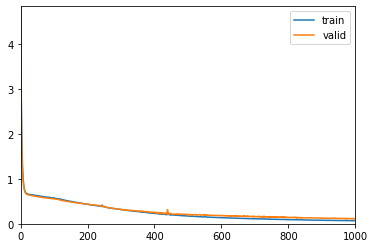

confusion_matrix
        true_E  true_N
pred_E     6.0     0.0
pred_N     0.0     3.0
trial_out_num: 1


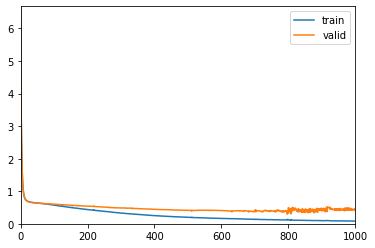

confusion_matrix
        true_E  true_N
pred_E     6.0     0.0
pred_N     0.0     3.0
trial_out_num: 2


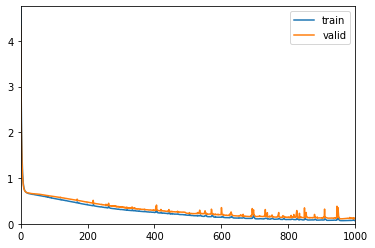

confusion_matrix
        true_E  true_N
pred_E     5.0     0.0
pred_N     0.0     3.0
trial_out_num: 3


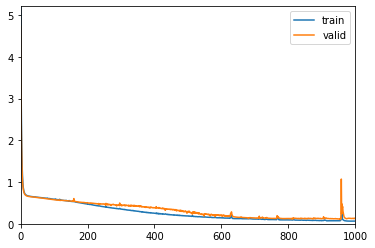

confusion_matrix
        true_E  true_N
pred_E     6.0     0.0
pred_N     0.0     3.0
trial_out_num: 4


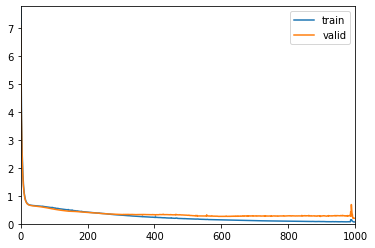

confusion_matrix
        true_E  true_N
pred_E     6.0     1.0
pred_N     0.0     2.0
trial_out_num: 5


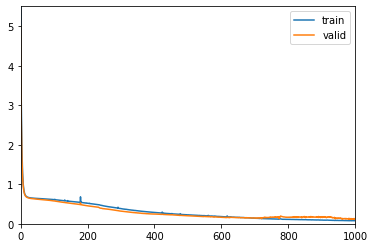

confusion_matrix
        true_E  true_N
pred_E     6.0     0.0
pred_N     0.0     3.0
trial_out_num: 6


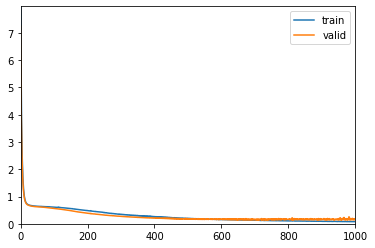

confusion_matrix
        true_E  true_N
pred_E     6.0     0.0
pred_N     0.0     3.0
trial_out_num: 7


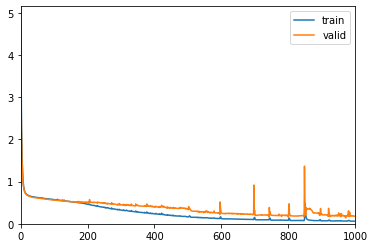

confusion_matrix
        true_E  true_N
pred_E     6.0     0.0
pred_N     0.0     3.0
trial_out_num: 8


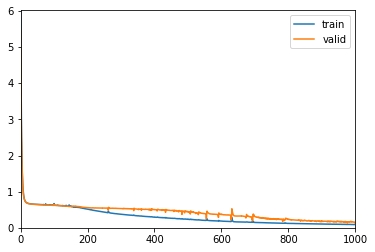

confusion_matrix
        true_E  true_N
pred_E     6.0     0.0
pred_N     0.0     3.0
trial_out_num: 9


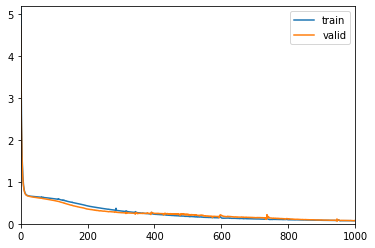

confusion_matrix
        true_E  true_N
pred_E     6.0     0.0
pred_N     0.0     3.0


In [198]:
# model train
max_loop_num=1
out_root_dir='../results/'
# time to make each model
# make an evaluate excel

for loop in range(max_loop_num):
    print('loop_num: '+str(loop))
    confusion_matrix = pd.DataFrame(np.zeros(shape=(nb_classes, nb_classes)), index=list(map(lambda str:'pred_'+str,classes)), columns=list(map(lambda str:'true_'+str,classes)))
    index_list=[str(i)+'_out' for i in range(MAX_TRIAL_NUM)]
    index_list.append('overall')
    df = pd.DataFrame(data=np.zeros(shape=(11, 9), dtype=np.float32),
                    index=index_list,
                    columns=['accuracy', 'precision', 'recall', 'f_measure','TP','FP','FN','TN','process_time'])
    architecture,reg,lr,filters,kernel_size,amsgrad=get_params()

    print('architecture__' + architecture)
    print('reg__' + str(reg))
    print('lr__' + str(lr))
    print('filters__' + str(filters))
    print('kernel_size__' + str(kernel_size))
    print('amsgrad__' + str(amsgrad))

    for trial_num in range(MAX_TRIAL_NUM):
        print('trial_out_num: '+str(trial_num))
        if subject=='B' and trial_num==2:
            continue
        x_train,y_train,x_test,y_test,x_val,y_val = make_datasets(test_num=trial_num)

        out_dir = out_root_dir \
                + 'architecture__' + architecture + '/' \
                + 'reg__' + str(reg) + '/' \
                + 'lr__' + str(lr) + '/' \
                + 'filters__' + str(filters) + '/' \
                + 'kernel_size__' + str(kernel_size) + '/' \
                + 'amsgrad__' + str(amsgrad) + '/' \
                + str(trial_num) + '_out' + '/'

        test_dir = create_dir(out_dir)
        if (test_dir is None):
            loop = loop - 1
            continue

        keras.backend.clear_session()

        # to use multi GPU
        # strategy = tf.distribute.MirroredStrategy()
        # with strategy.scope():

        build_model = modified_fcn_each_dim_build_model
        # build_model=attention_lstm_fcn_each_dim_build_model

        model = build_model(input_shapes, filters, kernel_size, lr, amsgrad, summary=False, reg=reg)
        
        # save init parameters
        model.save(out_dir + 'model_init.hdf5')

        # 学習曲線描画のための前準備
        mb = master_bar(range(nb_epochs))
        train_costs_lst = []
        valid_costs_lst = []
        test_costs_lst=[]
        x_bounds = [0, nb_epochs]
        y_bounds = None
        y_upper_bound=None
        # y_bounds=[0,1.5]
        min_val_loss=-1

        start = time.time()

        for epoch in mb:
            # shuffle before every epoch training
            if (shuff == True):
                x_train, y_train = shuffle(x_train, y_train)
            # convert string labels to binary forms
            y_train_binary, y_test_binary, y_val_binary = convertStringClassesToBinaryClasses(y_train, y_test, y_val)

            epoch_train_loss = 0
            epoch_test_loss = 0
            epoch_val_loss = 0
            train_num=0
            # train_num=iteration_num because batchsize=1
            for iteration in progress_bar(range(len(x_train)), parent=mb):
                loss, acc = model.train_on_batch(split_input_for_training(x_train[train_num]), y_train_binary[train_num].reshape(1, nb_classes))
                epoch_train_loss += loss  ################# change if monitor acc instead of loss
                train_num+=1
            
            epoch_train_loss = epoch_train_loss / len(x_train)
            epoch_test_loss=evaluate_for_epoch(model, x_test, y_test_binary)

            if val_split:
                epoch_val_loss = evaluate_for_epoch(model, x_val, y_val_binary)
                if (epoch_val_loss < min_val_loss or min_val_loss == -1):
                    # this is to choose finally the model that yields the best results on the validation set
                    model.save(out_dir + 'model_best.hdf5')
                    min_val_loss = epoch_val_loss
            else:  # we evaluate on the test
                if (epoch_test_loss < min_val_loss or min_val_loss == -1):
                    # this is to choose finally the model that yields the best results on the validation set
                    model.save(out_dir + 'model_best.hdf5')
                    min_val_loss = epoch_test_loss

            model.save(out_dir + 'model_curr.hdf5')

            # 損失関数の値の計算
            train_costs_lst.append(epoch_train_loss)
            test_costs_lst.append(epoch_test_loss)

            # learning curveの図示
            if y_bounds is None:
                # 1エポック目のみ実行
                y_bounds = [0, epoch_test_loss *
                            1.1 if y_upper_bound is None else y_upper_bound]

            t = np.arange(len(train_costs_lst))
            graphs = [[t, train_costs_lst], [t, test_costs_lst]]
            mb.update_graph(graphs, x_bounds, y_bounds)

            # 学習過程の出力
            # mb.write('EPOCH: {0:02d}, Training cost: {1:10.5f}, Validation cost: {2:10.5f}'.format(
            #     epoch+1, epoch_train_loss, epoch_test_loss))
            
            # end of trial

        process_time = time.time() - start

        model = load_model(out_dir + 'model_best.hdf5')

        confusion_matrix_f = evaluateModel(model, x_test, y_test_binary)
        evaluate_confusion_matrix(df,str(trial_num)+'_out',confusion_matrix_f,min_val_loss ,process_time)
        print('confusion_matrix')
        print(confusion_matrix_f)

    out_dir = out_root_dir \
                + 'architecture__' + architecture + '/' \
                + 'reg__' + str(reg) + '/' \
                + 'lr__' + str(lr) + '/' \
                + 'filters__' + str(filters) + '/' \
                + 'kernel_size__' + str(kernel_size) + '/' \
                + 'amsgrad__' + str(amsgrad) + '/'
    evaluate_confusion_matrix(df, 'overall', confusion_matrix, min_val_loss=None, process_time=None)

In [205]:
# printCAM to explain
def cas(model_path):
    # idx_to_explain corresponds to the id of the class to explain
    model = keras.models.load_model(model_path)
    
    for idx_to_explain in [0,1]:
        if idx_to_explain==0:
            # expert explanation
            # subjects=['A','F','G']
            subjects=['A','B','C','F','G','H']
        elif idx_to_explain==1:
            # novice explanation
            subjects=['D','E','I']
        for subject in subjects:
            print('subject:'+subject+' start')
            pp=PdfPages(out_root_dir + subject +'_level'+sub_level[subject]+ '.pdf')
            for trial_num in range(10):
                if subject=='B' and trial_num==2:
                    continue
                time_series_original = df_time_series.loc[subject,trial_num]

                w_k_c = model.layers[-1].get_weights()[0]  # weights for each filter k for each class c

                new_input_layer = model.inputs  # same input of the original model

                new_outpu_layer = [model.get_layer("conv1d_7").output,
                                model.layers[-1].output]  # output is both the original as well as the before last layer

                # new_outpu_layer = [model.get_layer("conv_final").output,
                #                 model.layers[-1].output]  # output is both the original as well as the before last layer

                new_function = keras.backend.function(new_input_layer, new_outpu_layer)

                new_feed_forward = new_function

                [conv_out, predicted] = new_feed_forward(split_input_for_training(time_series_original))

                # print('subject:'+subject+' '+'try_num:'+str(trial_num))
                # print('true_label:'+sub_level[subject])
                
                print('data: '+subject+str(trial_num))
                print("predicted_label:" + classes[np.argmax(predicted)])

                cas = np.zeros(dtype=float, shape=(conv_out.shape[1]))

                conv_out = conv_out[0, :, :]

                for k, w in enumerate(w_k_c[:, idx_to_explain]):
                    cas += w * conv_out[:, k]

                minimum = np.min(cas)
                if minimum < 0:
                    cas = cas + abs(minimum)
                else:
                    cas = cas - minimum

                cas = cas / max(cas)
                cas = cas * 100
                cas = cas.astype(int)

                # modify these values to present an appropriate color map
                x_head = time_series_original[:, 2]
                z_head = time_series_original[:, 3]
                y_head = time_series_original[:, 4]

                fig = plt.figure()
                # plot3d = fig.add_subplot(1,1,try_num+1, projection='3d')
                plot3d = fig.add_subplot(projection='3d')
                pltmap = plot3d.scatter(x_head, y_head, z_head,
                                        c=cas, cmap='jet', s=5, linewidths=0)
                ax = plt.gca()
                ax.set_title('try_num:'+str(trial_num)+' '+"predicted_label:" + classes[np.argmax(predicted)]+'\n'+
                                r'% of Expert is '+f'{predicted[0][0]*100.0:.2f}'+', Novice is '+f'{predicted[0][1]*100.0:.2f}')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_zticklabels([])
                ax.set_xlabel('x_head')
                ax.set_ylabel('y_head')
                ax.set_zlabel('z_head')
                ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
                ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
                ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
                clbr = plt.colorbar(pltmap)
                clbr.set_ticks([])
                # plt.savefig(out_root_dir + surgery_name + '.pdf')
                pp.savefig(fig)
                plt.close()
            # plt.savefig(out_root_dir + subject +'_level'+mapExpertiseLevelBySurgeryName[surgery_type+'_'+subject+'000']+ '.pdf')
            pp.close()
            print('subject:'+subject+' end')
print('all end!')

cas(model_path='../results/architecture__fcn/reg__1e-05/lr__0.0005/filters__8/kernel_size__5/amsgrad__0/1_out/model_best.hdf5')

all end!
subject:A start
data: A0
predicted_label:E
data: A1
predicted_label:E
data: A2
predicted_label:E
data: A3
predicted_label:E
data: A4
predicted_label:E
data: A5
predicted_label:E
data: A6
predicted_label:E
data: A7
predicted_label:E
data: A8
predicted_label:E
data: A9
predicted_label:E
subject:A end
subject:B start
data: B0
predicted_label:E
data: B1
predicted_label:E
data: B3
predicted_label:E
data: B4
predicted_label:E
data: B5
predicted_label:E
data: B6
predicted_label:E
data: B7
predicted_label:E
data: B8
predicted_label:E
data: B9
predicted_label:E
subject:B end
subject:C start
data: C0
predicted_label:E
data: C1
predicted_label:E
data: C2
predicted_label:E
data: C3
predicted_label:E
data: C4
predicted_label:E
data: C5
predicted_label:E
data: C6
predicted_label:E
data: C7
predicted_label:E
data: C8
predicted_label:E
data: C9
predicted_label:E
subject:C end
subject:F start
data: F0
predicted_label:E
data: F1
predicted_label:E
data: F2
predicted_label:E
data: F3
predicted_la

In [200]:
# trim to same length

"""
df_time_series=pd.DataFrame(index=subjects,columns=[i for i in range(MAX_TRIAL_NUM)])
min_sequence_length=1000000
# get min time_series_length
for subject in subjects:
    for trial_num in range(MAX_TRIAL_NUM):
        df_log=pd.read_table('../OIL_DATA/Eyelog/log_data/Eyelog_'+subject+'00'+str(trial_num)+'.txt', header=None)
        if min_sequence_length>len(df_log.values):
            min_sequence_length=len(df_log.values)
for subject in subjects:
    for trial_num in range(MAX_TRIAL_NUM):
        df_log=pd.read_table('../OIL_DATA/Eyelog/log_data/Eyelog_'+subject+'00'+str(trial_num)+'.txt', header=None)
        df_time_series.loc[subject,trial_num]=df_log.values[:min_sequence_length]

def make_datasets(test_num):
    x_train=[]
    x_val=[]
    x_test=[]
    y_train=[]
    y_val=[]
    y_test=[]
    for subject in subjects:
        for trial_num in range(MAX_TRIAL_NUM):
            if trial_num==test_num:
                x_test.append(df_time_series.loc[subject,trial_num].tolist())
                if sub_level[subject]=='N':
                    y_test.append('N')
                elif sub_level[subject]=='E':
                    y_test.append('E')
            else:
                x_train.append(df_time_series.loc[subject,trial_num].tolist())
                if sub_level[subject]=='N':
                    y_train.append('N')
                elif sub_level[subject]=='E':
                    y_train.append('E')
            
    fit_encoder(y_train, y_test, y_val)
    x_train=np.array(x_train)
    x_test=np.array(x_test)
    x_val=np.array(x_test)
    return x_train,y_train,x_test,y_test,x_val,y_val

# define models
def temp_build_model(shape,summary=False):
    input_layer = Input(batch_shape=shape)
    conv_1d_output_layer = Conv1D(8, 3, padding='same')(input_layer)
    flatten_output_layer = Flatten()(conv_1d_output_layer)
    out = Dense(2, activation='sigmoid',kernel_initializer='he_normal')(flatten_output_layer)
    
    # create the model and link input to output
    model = Model(inputs=input_layer, outputs=out)

    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,amsgrad=0)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])

    # show summary if specified
    if summary == True:
        model.summary()

    return model

keras.backend.clear_session()
x_train,y_train,x_test,y_test,x_val,y_val=make_datasets(3)
y_train_binary, y_test_binary, y_val_binary = convertStringClassesToBinaryClasses(y_train, y_test, y_val)

model=temp_build_model(shape=x_train.shape)

history=model.fit(x_train, y_train_binary, validation_split=0.1, batch_size=1, epochs=100)

%matplotlib inline
plt.plot(range(100), history.history['loss'], label='loss')
plt.plot(range(100), history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

"""

'\ndf_time_series=pd.DataFrame(index=subjects,columns=[i for i in range(MAX_TRIAL_NUM)])\nmin_sequence_length=1000000\n# get min time_series_length\nfor subject in subjects:\n    for trial_num in range(MAX_TRIAL_NUM):\n        df_log=pd.read_table(\'../OIL_DATA/Eyelog/log_data/Eyelog_\'+subject+\'00\'+str(trial_num)+\'.txt\', header=None)\n        if min_sequence_length>len(df_log.values):\n            min_sequence_length=len(df_log.values)\nfor subject in subjects:\n    for trial_num in range(MAX_TRIAL_NUM):\n        df_log=pd.read_table(\'../OIL_DATA/Eyelog/log_data/Eyelog_\'+subject+\'00\'+str(trial_num)+\'.txt\', header=None)\n        df_time_series.loc[subject,trial_num]=df_log.values[:min_sequence_length]\n\ndef make_datasets(test_num):\n    x_train=[]\n    x_val=[]\n    x_test=[]\n    y_train=[]\n    y_val=[]\n    y_test=[]\n    for subject in subjects:\n        for trial_num in range(MAX_TRIAL_NUM):\n            if trial_num==test_num:\n                x_test.append(df_time_ser